<a href="https://colab.research.google.com/github/Usually-zz/2021_IMC/blob/main/fixed_psi_size%3E50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma']) + 1e-6

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(no, 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])  + 1e-6

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

def compute_r_v_2(Y, S, Theta):
  """Need to compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(no, -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  p_data = torch.logsumexp(p_data, dim=1)

  r = p_data_given_z_d0.T + log_delta[0] - p_data
  v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  return r.T, v.T.reshape(-1,nc,nc), p_data, p_singlet

In [3]:
def Q(Theta, Y, S, r, v, ignored_indices):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rd0z = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_rd1g = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]


  q1 = log_rd0z * r.exp()
  q2 = log_rd1g * v.exp()

  return q1.sum() + q2.sum()

In [4]:
%pip install scanpy

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 127 kB 55.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=7bf22c067ba06549d3de530fd72d2cd721759d8885ea0069db92d74a74b38d07
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=9f8649d87c9fb77a72b0a8e0c25a8bf81815f5e6444628da7a016ca9e5f9c68d
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=2bc261c1198c5272325d7d5def7b021ba701ff2946913e45176be288e8a80f0b
  Stored in directory: /root/.cache/

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

import scanpy as sc
adata = sc.read_h5ad("basel_zuri_subsample.h5ad")
adata = adata[adata.obs.Area > 50,:]

cell_sel = np.random.choice(adata.shape[0], size=1000)
adata = adata[cell_sel,:]

Mounted at /content/gdrive


In [6]:
YY = adata.X
SS = adata.obs.Area

nc = 15 # number of clusters?
nf = YY.shape[1]
no = YY.shape[0]

YY = np.arcsinh(YY / 5.)

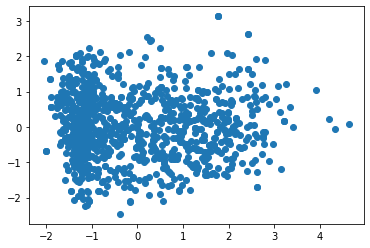

In [7]:
pca = PCA(n_components=2)
Z = pca.fit_transform(YY)

plt.scatter(Z[:,0], Z[:,1]);

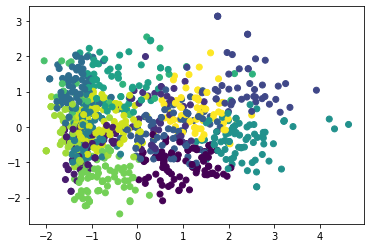

In [8]:
N_INIT = 10

kms = [KMeans(nc).fit(YY) for i in range(N_INIT)]
inertias = [k.inertia_ for k in kms]
km = kms[np.argmin(np.array(inertias))]
init_labels = km.labels_

plt.scatter(Z[:,0], Z[:,1], c=init_labels);

In [9]:
inertias

[2211.8133752697113,
 2216.310796677602,
 2224.6692195625333,
 2231.0703884704476,
 2231.952805989725,
 2230.2697082630125,
 2227.232846753197,
 2238.640730691941,
 2235.2894788505027,
 2218.5925450604836]

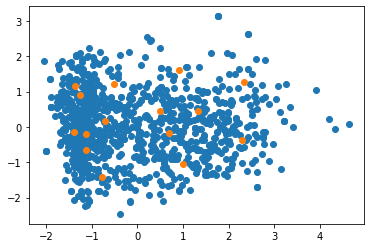

In [10]:
mu_init = np.array([YY[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
sigma_init = np.array([YY[init_labels == i,:].std(0) for i in np.unique(init_labels)])

psi_init = np.array([SS[init_labels == i].mean() for i in np.unique(init_labels)])
omega_init = np.array([SS[init_labels == i].std() for i in np.unique(init_labels)])
pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
tau_init = np.ones((nc,nc))
tau_init = tau_init / tau_init.sum()

Z_mu_init = pca.transform(mu_init)

plt.scatter(Z[:,0], Z[:,1]);
plt.scatter(Z_mu_init[:,0], Z_mu_init[:,1]);

In [11]:
## Very slightly corrupted theta:
Theta = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}
#Theta['is_delta'].requires_grad = False
#Theta['is_tau'].requires_grad = False
Theta['log_psi'].requires_grad = False

In [12]:
Theta['log_psi'].exp()

tensor([127.0638,  91.9474, 123.5714, 111.8000, 117.5955, 109.6286, 113.1939,
        135.5366, 122.4429, 134.0909, 113.4762, 102.9157, 106.3175, 103.8611,
        115.3731], dtype=torch.float64)

In [13]:
N_ITER = 1000
N_ITER_OPT = 100
lr = 1e-3
tol = 1e-2

Y = torch.tensor(YY)
S = torch.tensor(SS)

In [14]:
opt = optim.Adam(Theta.values())

ls = []
qs = []
for i in range(N_ITER):

  print(i)

  # E Step:
  with torch.no_grad():
    r, v, L, p_singlet_em = compute_r_v_2(Y, S, Theta)

  # M step (i.e. maximizing Q):
  for j in range(N_ITER_OPT):

    opt.zero_grad()
    q = -Q(Theta, Y, S, r, v, None)
    # print(q)
    q.backward()
    opt.step()
    
  if i % (10 - 1) == 0:
    print("L: {}; {}; {}".format(L.sum(), F.log_softmax(Theta['is_delta'], 0).exp(), F.log_softmax(Theta['is_pi'], 0).exp()))

  # Check for convergence
  if i > 0 and abs(ls[-1] - L.sum()) < tol:
    break

  qs.append(-q.sum())
  ls.append(L.sum())

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to 

L: 102456.67077616298; tensor([0.9398, 0.0602], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0850, 0.0598, 0.0384, 0.0407, 0.0812, 0.0760, 0.1073, 0.0892, 0.0633,
        0.0117, 0.0229, 0.0859, 0.0683, 0.0974, 0.0730], dtype=torch.float64,
       grad_fn=<ExpBackward>)
1
2
3
4
5
6
7
8
9
L: 112599.64036133539; tensor([0.6637, 0.3363], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0497, 0.0251, 0.0290, 0.0252, 0.0604, 0.0892, 0.1980, 0.0711, 0.0357,
        0.0181, 0.0308, 0.0954, 0.1061, 0.0591, 0.1072], dtype=torch.float64,
       grad_fn=<ExpBackward>)
10
11
12
13
14
15
16
17
18
L: 115977.47593331322; tensor([0.3843, 0.6157], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0247, 0.0238, 0.0216, 0.0195, 0.0524, 0.1013, 0.2337, 0.0660, 0.0362,
        0.0232, 0.0317, 0.0738, 0.1052, 0.0558, 0.1314], dtype=torch.float64,
       grad_fn=<ExpBackward>)
19
20
21
22
23
24
25
26
27
L: 117299.49910445145; tensor([0.2847, 0.7153], dtype=torch.float64, grad_fn=<ExpBack

In [15]:
F.log_softmax(torch.tensor(Theta['is_delta']), 0).exp()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([0.2293, 0.7707], dtype=torch.float64)

In [16]:
with torch.no_grad():
  r, v, L, p_singlet_em = compute_r_v_2(Y,S,Theta)

p_singlet_em = p_singlet_em.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#adata.obs

In [17]:
adata.obs['p_singlet_em'] = p_singlet_em
adata.obs['probability_single_cell_em'] = adata.obs.p_singlet_em

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


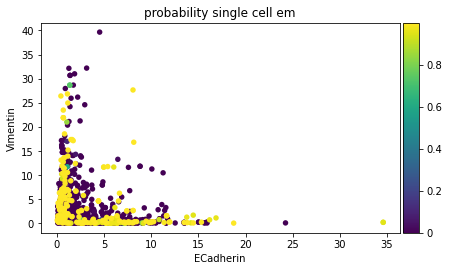

In [18]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_single_cell_em')

In [19]:
p_doublet_em = 1 - p_singlet_em
adata.obs['p_doublet_em'] = p_doublet_em
adata.obs['probability_doublet_cell_em'] = adata.obs.p_doublet_em

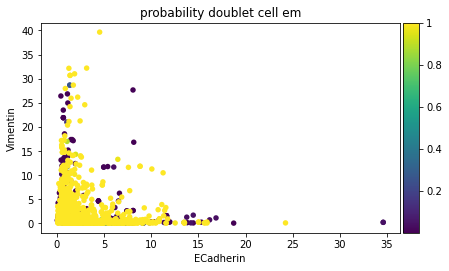

In [20]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_doublet_cell_em')

Text(0, 0.5, 'cell size')

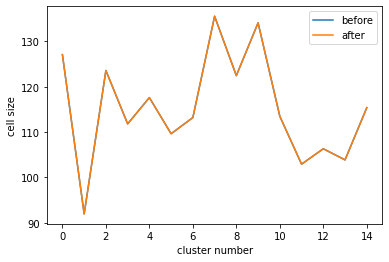

In [22]:
plt.plot(torch.tensor(psi_init), label="before")
plt.plot(Theta['log_psi'].exp().detach().numpy(), label="after")
plt.legend()
plt.xlabel("cluster number")
plt.ylabel("cell size")

Text(0, 0.5, 'll')

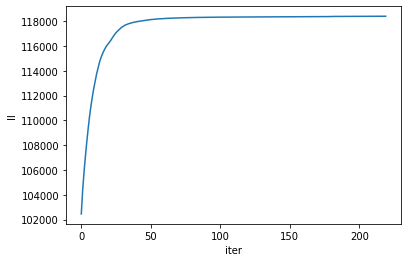

In [24]:
plt.plot(ls)
plt.xlabel("iter")
plt.ylabel("ll")

In [25]:
def ll(Y, S, Theta):
  """compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'], 0)
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1), 0).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'], 0)

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(Y.shape[0], -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  #p_data = torch.logsumexp(p_data, dim=1)

  #r = p_data_given_z_d0.T + log_delta[0] - p_data
  #v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  #p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  #return r.T, v.T.reshape(-1,nc,nc), -p_data, p_singlet

  return torch.logsumexp(p_data, dim=1).sum()

In [26]:
## Very slightly corrupted theta:
Theta1 = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

Theta1 = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta1.items()}
#Theta1['is_delta'].requires_grad = False
#Theta1['is_tau'].requires_grad = False
Theta1['log_psi'].requires_grad = False

In [27]:
opt = optim.Adam(Theta1.values())

loss = []
for epoch in range(N_ITER * N_ITER_OPT):

  #print(i)

  opt.zero_grad()
  nlls = -ll(Y, S, Theta1) #nll
  nlls.backward()
  opt.step()

  if epoch % (100 - 1) == 0:
    print("L: {}; {}; {}".format(nlls, F.log_softmax(Theta1['is_delta'], 0).exp(), F.log_softmax(Theta1['is_pi'], 0).exp()))
      
  if epoch > 0 and abs(loss[-1] - nlls) < tol:
    break
  
  loss.append(nlls)

L: -102456.67077616298; tensor([0.9499, 0.0501], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0939, 0.0571, 0.0420, 0.0450, 0.0889, 0.0701, 0.0981, 0.0821, 0.0699,
        0.0110, 0.0210, 0.0831, 0.0631, 0.1079, 0.0671], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -104575.44034178359; tensor([0.9392, 0.0608], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0849, 0.0519, 0.0389, 0.0409, 0.0803, 0.0760, 0.1081, 0.0887, 0.0632,
        0.0118, 0.0233, 0.0913, 0.0696, 0.0975, 0.0733], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -106217.98582272569; tensor([0.9249, 0.0751], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0784, 0.0457, 0.0389, 0.0385, 0.0747, 0.0798, 0.1202, 0.0862, 0.0576,
        0.0124, 0.0261, 0.0944, 0.0767, 0.0897, 0.0809], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -107680.7521198191; tensor([0.9067, 0.0933], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0727, 0.0414, 0.0360, 0.0374, 0.0705, 0.0820, 0.131

In [28]:
F.log_softmax(Theta1['is_delta'], 0).exp()

tensor([0.2455, 0.7545], dtype=torch.float64, grad_fn=<ExpBackward>)

In [29]:
with torch.no_grad():
  r, v, L, p_singlet_mle = compute_r_v_2(Y,S,Theta1)

p_singlet_mle = p_singlet_mle.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


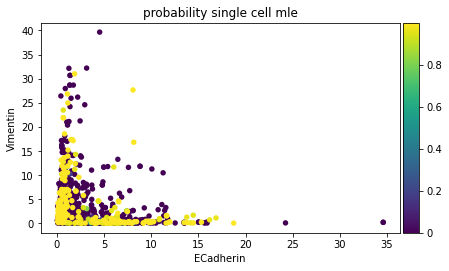

In [30]:
adata.obs['p_singlet_mle'] = p_singlet_mle
adata.obs['probability_single_cell_mle'] = adata.obs.p_singlet_mle
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_single_cell_mle')

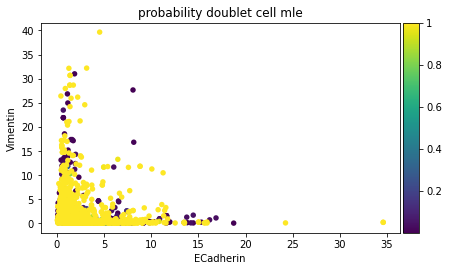

In [31]:
p_doublet_mle = 1 - p_singlet_mle
adata.obs['p_doublet_mle'] = p_doublet_mle
adata.obs['probability_doublet_cell_mle'] = adata.obs.p_doublet_mle
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_doublet_cell_mle')

Text(0, 0.5, 'cell size')

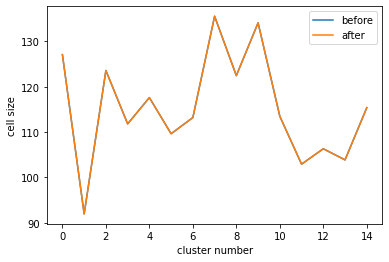

In [32]:
plt.plot(torch.tensor(psi_init), label="before")
plt.plot(Theta1['log_psi'].exp().detach().numpy(), label="after")
plt.legend()
plt.xlabel("cluster number")
plt.ylabel("cell size")

Text(0, 0.5, 'nll')

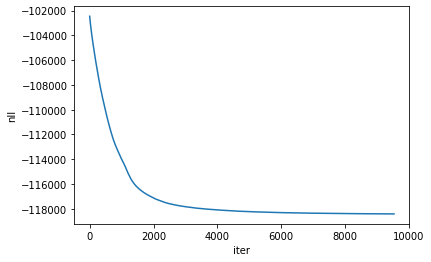

In [35]:
plt.plot(loss)
plt.xlabel("iter")
plt.ylabel("nll")

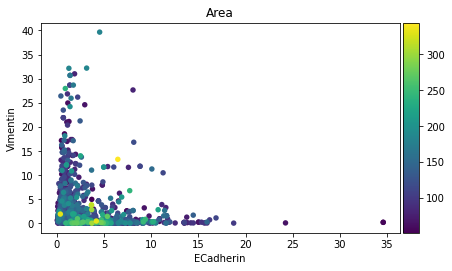

In [36]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'Area')

Text(0, 0.5, 'Count')

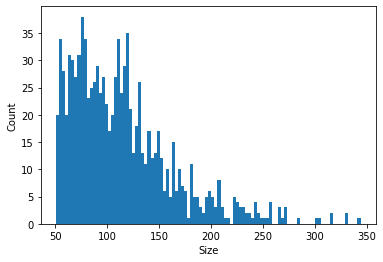

In [37]:
plt.hist(adata.obs['Area'], bins = 100)
plt.xlabel("Size")
plt.ylabel("Count")